# Importing relevant modules

In [77]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
# Plotting

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import tkinter as tk
from tkinter.filedialog import askopenfilename
import ipywidgets as widgets
from IPython.display import clear_output
from ipywidgets import interact, interact_manual
from pathlib import Path
import io

In [78]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, ColumnDataSource
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import PRGn, RdYlGn
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.layouts import row, column
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter

# Using interact to select correct file and sheet name

In [79]:
file_import = widgets.FileUpload(description='Open', multiple=True)
display(file_import)

FileUpload(value=(), description='Open', multiple=True)

In [80]:
df=pd.read_excel(file_import.value[0]['name'],sheet_name=None)
#print(df)
def show_sheet(choice):
    global df
    global df2
    df2 = df[choice]
    df2 = df2.fillna(0)
    display(df2.head(10))
    
interact(show_sheet, choice = widgets.Dropdown(options = df.keys(), 
                                               description = 'Sheet choice'))

interactive(children=(Dropdown(description='Sheet choice', options=('PerfDNA', 'Comp(%)', 'TIC', 'JMP', 'Raw D…

<function __main__.show_sheet(choice)>

# Choosing data labels and data points

In [81]:
def label_pick(row_tup, col):
    start, end = row_tup
    global select_rows
    select_rows = df2.iloc[start:end,col:]
    return select_rows

label = '''Please select rows which contain labels you wish to keep'''
print(label)

row_slider = widgets.IntRangeSlider(value=(2,5),min=0, max=10, step=1, description = 'Selected rows:',align_items='stretch', 
    style= {'description_width': 'initial'})

col_slider = widgets.IntSlider(value=0,min=0, max=10, step=1, description = 'Dropped columns:',align_items='stretch', 
    style= {'description_width': 'initial'})

interact(label_pick, row_tup = row_slider, col = col_slider)

Please select rows which contain labels you wish to keep


interactive(children=(IntRangeSlider(value=(2, 5), description='Selected rows:', max=10, style=SliderStyle(des…

<function __main__.label_pick(row_tup, col)>

In [82]:
def data_pick(x,y):
    global df
    global perfume_df
    perfume_df = df2.iloc[x:,y:]
    return perfume_df

label1 = 'Please select the number of rows to drop so that only the PRMs and their relative concentrations are displayed'
print(label1)

interact(data_pick, 
         x=widgets.IntSlider(min=0, 
                             max=10, 
                             step=1, 
                             value=7,
                             description = 'Dropped rows:',
                            align_items='stretch', 
                            style= {'description_width': 'initial'}),
        y = widgets.IntSlider(min=0, 
                             max=10, 
                             step=1, 
                             value=0,
                             description = 'Dropped columns:',
                            align_items='stretch', 
                            style= {'description_width': 'initial'}))

Please select the number of rows to drop so that only the PRMs and their relative concentrations are displayed


interactive(children=(IntSlider(value=7, description='Dropped rows:', max=10, style=SliderStyle(description_wi…

<function __main__.data_pick(x, y)>

# Selecting the index column

In [83]:
choice = ''
def change_index(Select):
    global choice
    choice = Select
    global perfume_new
    perfume_new = perfume_df.set_index(choice, inplace= False)
    display(perfume_new)
print('''Choose the column which contains the list of PRMs''')
interact(change_index, Select = widgets.Dropdown(options=list(perfume_df.columns)))

Choose the column which contains the list of PRMs


interactive(children=(Dropdown(description='Select', options=('Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnam…

<function __main__.change_index(Select)>

# Scaling of data

In [84]:
perfume_new_t = perfume_new.T
#print(perfume_new.head())
features = perfume_new_t.columns
print('Index of all the PRM labels:')
print(features)

pca_perf = PCA(n_components=6, svd_solver = 'auto')
xperf = perfume_new_t.loc[:, features].values
# .loc allows the return of select rows/columns from the dataframe
xperf = StandardScaler().fit_transform(xperf) # normalizing the features

#able to see the statistical data extracted
print('\nScaled data:')
print(xperf)

Index of all the PRM labels:
Index(['Ethyl butyrate', 'Ethyl 2-methyl butyrate', 'cis-3-Hexenol',
       'iso-Amyl Acetate', 'iso-Propyl 2-methyl butyrate', 'Prenyl acetate',
       'Manzanate', 'alpha-Pinene', 'Ethyl acetoacetate', 'Benzaldehyde',
       ...
       'Trimofix O', 'Galaxolide', 'Tonalid', 'delta-Muscenone',
       'Benzyl salicylate', 'Phenyl ethyl phenyl acetate', 'Musk C14',
       'Cyclohexandecenone', 'Ambrettolide', 'Ethylene brassylate'],
      dtype='object', name='Unnamed: 0', length=190)

Scaled data:
[[-0.10287251  0.16469245 -0.24896214 ... -0.05944383  0.
  -0.05944383]
 [-0.10287251 -0.1780802  -0.24896214 ... -0.05944383  0.
  -0.05944383]
 [-0.10287251 -0.11752229 -0.24896214 ... -0.05944383  0.
  -0.05944383]
 ...
 [-0.10287251 -0.1780802  -0.24896214 ... -0.05944383  0.
  -0.05944383]
 [-0.10287251  0.12330273 -0.24896214 ... -0.05944383  0.
  -0.05944383]
 [-0.10287251  0.59059005 -0.24896214 ... -0.05944383  0.
  -0.05944383]]


# PCA transformation of data

In [85]:
principalComponents_perf = pca_perf.fit_transform(xperf)
# array of the 2 PC values for each sample of data eg each person
pca_df = pd.DataFrame(data=principalComponents_perf, columns = ['pc1','pc2','pc3','pc4','pc5','pc6'])
print('PCA table:')
display(pca_df)

PCA table:


,pc1,pc2,pc3,pc4,pc5,pc6
0,1.436201,-2.192837,-3.360884,1.168181,2.595048,0.745901
1,0.058002,-3.465989,-0.636106,0.058683,1.086661,-2.785548
2,-0.490874,-1.436071,-1.396732,-0.237986,2.050407,4.624302
3,1.884894,-0.224545,-1.078010,0.094760,1.530605,3.147525
4,-2.213858,-2.852718,-1.225381,-1.205033,-1.752125,-2.347067
...,...,...,...,...,...,...
279,0.442027,-2.456145,0.252896,1.758455,2.861843,-1.581377
280,-2.853068,-0.324626,-0.147672,-1.498485,-1.136547,1.616683
281,-1.281128,-0.691970,0.102397,-0.478605,-0.374840,0.084741
282,0.473262,-2.768176,-1.737747,0.340629,2.356235,-1.923345


# Scree Plot

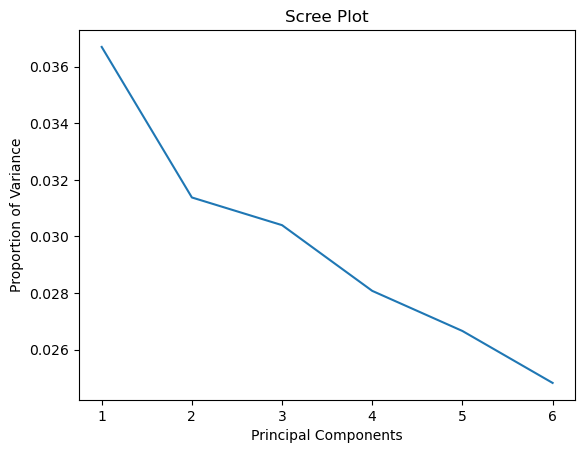

In [86]:
PC_values = np.arange(pca_perf.n_components_) + 1
plt.plot(PC_values, 
         pca_perf.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance')
plt.show()

# Adding Brand + Country labels to data frame

In [87]:
new_header = select_rows.T.iloc[0] #grab the first row for the header
dat2 = select_rows.T[1:] #take the data less the header row
dat2.columns = new_header #set the header row as the df header
dat2 = dat2.reset_index(drop=True)
dat1 = pca_df.reset_index(drop=True)

final_df = dat1.join(dat2)
final_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,Brand,Manufacturer,Country
0,1.436201,-2.192837,-3.360884,1.168181,2.595048,0.745901,Surf Excel Quick Wash,Unilever,India
1,0.058002,-3.465989,-0.636106,0.058683,1.086661,-2.785548,Surf Excel Easy Wash,Unilever,India
2,-0.490874,-1.436071,-1.396732,-0.237986,2.050407,4.624302,Rin,Unilever,India
3,1.884894,-0.224545,-1.078010,0.094760,1.530605,3.147525,Wheel Act Lem & Jasmine,Unilever,India
4,-2.213858,-2.852718,-1.225381,-1.205033,-1.752125,-2.347067,Persil Non Bio,Unilever,UK


# Counting number of countries

In [88]:
total_count = {}
colour_count = {}



for i in final_df['Country'].values.tolist():
    try:
        total_count[i] += 1
    except:
        total_count[i] = 1
        #colour_count[i] = color[cc]
        #cc+=1
        
print ('Dictionary of countries: \n', total_count, 2*'\n',
       'Total countries = {}, Total products = {}'.format(len(total_count.keys()),
                                                         sum(total_count.values())))


Dictionary of countries: 
 {'India': 32, 'UK': 21, 'Turkey': 14, 'South Africa': 15, 'Mexico': 14, 'China': 23, 'Brazil': 7, 'Saudi Arabia': 16, 'Thailand': 8, 'Egypt': 12, 'Germany': 27, 'Belgium': 1, 'USA': 14, 'Philippines': 12, 'Chile': 4, 'Argentina': 1, 'Kenya': 2, 'Nigeria': 4, 'Poland': 6, 'France': 3, 'Vietnam': 6, 'Russia': 13, 'Japan': 2, 'Morocco': 6, 'Iran': 2, 'Italy': 2, 'Canada': 1, 'Pakistan': 4, 'Colombia': 6, 'Malaysia': 1, 'Peru': 3, 'Oman': 1, 'Philppines': 1} 

 Total countries = 33, Total products = 284


# Generating random colours using hex colour for countries

In [89]:
number_of_colors = len(total_count.keys())
print(number_of_colors)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
print(color)
cc = 0
colour_count = total_count.copy()
for i in colour_count.keys():
    colour_count[i] = color[cc]
    cc+=1

33
['#E12EB8', '#D3D959', '#856CA2', '#EE095D', '#C0975B', '#E2E3F5', '#49A0C4', '#828461', '#380755', '#340D0F', '#7DACFF', '#F1BEB6', '#7DB122', '#D97EEE', '#67C804', '#66A846', '#3A0C03', '#FD19B4', '#01D2B2', '#EBE0D7', '#4CDB65', '#FB1BCD', '#F473CF', '#37D949', '#E674E4', '#EB6998', '#3DE279', '#1730F7', '#99E7EB', '#B64EC4', '#D4B57C', '#8B9380', '#E925BF']


# Custom Colour modification
**Feel free to change the colour of different countries to your own custom ones**

In [90]:
from tkinter import colorchooser

colour_count['India'] = 'orange'
colour_count['China'] = 'red'
colour_count['UK'] = 'blue'
colour_count['USA'] = 'cyan'
colour_count['Turkey'] = 'maroon'
colour_count['South Africa'] = 'limegreen'
colour_count['Mexico'] = 'darkgreen'
colour_count['Saudi Arabia'] = 'green'
colour_count['Germany'] = 'dimgrey'
colour_count['Egypt'] = 'tan'
colour_count['Thailand'] = 'purple'
colour_count['Russia'] = 'royalblue'
colour_count['Pakistan'] = 'olivedrab'
colour_count['Morocco'] = 'coral'
colour_count['Kenya'] = 'orchid'
#print(colour_count)

count_list = list(colour_count.keys())
colours = list(colour_count.values())

# Run the code below for an interactive version of colour choosing. 
If you want to reset colours to the defualt ones above, simply run the cell above again

In [91]:
country = count_list[0] # defualts country to first in count_list

def change_colour(update, country_input, col):
    try:
        if update == True:
            colour_count[country_input] = col
            global country
            country = country_input
    except:
        print('Invalid country or colour')
        
def click():
    global update
    if update == True:
        update = False
    else:
        update = True
    print(col)
    
interact(change_colour,
update = widgets.ToggleButton(
    description = 'Toggle updates',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Confirm',
    icon='gear',
    ), 
country_input = widgets.Dropdown(
    options=sorted(count_list),
    value='India',
    layout={'width': 'max-content'},
    description='Country select:',
    disabled=False,
    align_items='stretch', 
    style= {'description_width': 'initial'}),
col = widgets.ColorPicker(
    concise=False,
    description='Pick a color:',
    value=colour_count[country],
    disabled=False,
    align_items = 'stretch'
)
    )

interactive(children=(ToggleButton(value=False, description='Toggle updates', icon='gear', tooltip='Confirm'),…

<function __main__.change_colour(update, country_input, col)>

# Appending the custom colours to the main dataframe

In [92]:
colour_list = []
for country in dat2['Country'].values.tolist():
    colour_list.append(colour_count[country])
col_array = np.array(colour_list)
final_df['Colour'] = col_array.tolist()
final_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,Brand,Manufacturer,Country,Colour
0,1.436201,-2.192837,-3.360884,1.168181,2.595048,0.745901,Surf Excel Quick Wash,Unilever,India,orange
1,0.058002,-3.465989,-0.636106,0.058683,1.086661,-2.785548,Surf Excel Easy Wash,Unilever,India,orange
2,-0.490874,-1.436071,-1.396732,-0.237986,2.050407,4.624302,Rin,Unilever,India,orange
3,1.884894,-0.224545,-1.078010,0.094760,1.530605,3.147525,Wheel Act Lem & Jasmine,Unilever,India,orange
4,-2.213858,-2.852718,-1.225381,-1.205033,-1.752125,-2.347067,Persil Non Bio,Unilever,UK,blue


# NEW WITH BOKEH - COUNTRY COORDINATES

In [74]:
def count_cap(count_file):
    if len(count_file)!=0:
        global fil
        fil = pd.read_excel(count_file[0]['name'], sheet_name=None)
        if len(fil.keys())>1:
            def show_sheet(choice):
                global scent_df
                global df2
                df2 = fil[choice]
                df2 = df2.fillna(0)
                display(df2.head(10))
            interact(show_sheet, choice = widgets.Dropdown(options = fil.keys(), 
                                               description = 'Sheet choice'))
        else:
            display(fil[next(iter(fil))])
interact(count_cap, count_file = widgets.FileUpload(description='Open', multiple=True))

interactive(children=(FileUpload(value=(), description='Open', multiple=True), Output()), _dom_classes=('widge…

<function __main__.count_cap(count_file)>

In [136]:
import plotly.express as px
import pandas as pd


# Import data from GitHub
data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminder_with_codes.csv')


# Create basic choropleth map
fig = px.choropleth(data, locations='iso_alpha', color='gdpPercap', hover_name='country',
                    projection='natural earth', title='GDP per Capita by Country')
fig.show()

In [139]:
%pip install folium
import folium
%

Note: you may need to restart the kernel to use updated packages.


In [141]:
from folium.plugins import MarkerCluster
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

AttributeError: 'dict' object has no attribute 'iloc'

# World map projection

In [133]:
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import get_provider, Vendors

output_file("tile.html")

tile_provider = get_provider(Vendors.CARTODBPOSITRON)

# range bounds supplied in web mercator coordinates
p = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

show(p)

# Grouping scent types
**Product 1 (Surf Excel Quick Wash) has the following values: Aldehydic = 1.7, Amber = 0.0, Aromatic = 13.1**

In [93]:
file_import = widgets.FileUpload(description='Open', multiple=True)
display(file_import)

FileUpload(value=(), description='Open', multiple=True)

# 8 seconds to load

In [94]:
new_df=pd.read_excel(file_import.value[0]['name'],sheet_name=None)
#print(new_df)
def show_sheet(choice):
    display(new_df[choice].fillna(0).head(10))
    global scent_df
    scent_df = new_df[choice].fillna(0)
    
interact(show_sheet, choice = widgets.Dropdown(options = new_df.keys(), 
                                               description = 'Sheet choice'))

interactive(children=(Dropdown(description='Sheet choice', options=('PerfDNA', 'Comp(%)', 'TIC', 'JMP', 'Raw D…

<function __main__.show_sheet(choice)>

# 3 seconds to load

In [ ]:
# alternative method to reading excel values into dataframes
'''file = file_import.value[0]
import io
import pandas as pd
scent_df = pd.read_excel(io.BytesIO(file.content),sheet_name=None)
def show_sheet(choice):
    display(new_df[choice].head())
    global scent_df
    scent_df = new_df[choice]
interact(show_sheet, choice = widgets.Dropdown(options = scent_df.keys(), 
                                               description = 'Sheet choice'))
#scent_df.head()'''

In [95]:
def scent_pick(row_tup,col_tup):
    r_start, r_end = row_tup
    global scent_select_rows
    scent_select_rows = scent_df.iloc[r_start:r_end,col_tup:]
    return scent_select_rows

label = '''Please select rows and columns which contains the different scent types and their respective data points'''
print(label)

row_slider = widgets.IntRangeSlider(value=(9,27),min=0, max=30, step=1, description = 'Select rows:',align_items='stretch', 
    style= {'description_width': 'initial'})

col_slider = widgets.IntSlider(value=1,min=0, max=10, step=1, description = 'Select columns:',align_items='stretch', 
    style= {'description_width': 'initial'})

interact(scent_pick, row_tup = row_slider, col_tup = col_slider)

Please select rows and columns which contains the different scent types and their respective data points


interactive(children=(IntRangeSlider(value=(9, 27), description='Select rows:', max=30, style=SliderStyle(desc…

<function __main__.scent_pick(row_tup, col_tup)>

In [96]:
choice = ''
def scent_change_index(Select):
    global choice
    choice = Select
    global scent_select_rows
    global scent_type
    scent_type = scent_select_rows.set_index(choice, inplace= False)
    display(scent_type)
print('''Choose the column which contains the list of PRMs''')
interact(scent_change_index, Select = widgets.Dropdown(options=list(scent_select_rows.columns)))

Choose the column which contains the list of PRMs


interactive(children=(Dropdown(description='Select', options=('Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnam…

<function __main__.scent_change_index(Select)>

In [97]:
#print(scent_type)
# chooses row via indexing after single iteration is finished
counting = 0

# Counts number of identified scents (for better data representation on plot)
no_count = 0
# List/array to add to final dataframe
scent_lib = []

for ind in scent_type:
    cur_scent = '\n'
    for index, row in scent_type.iterrows():
        if row[counting]<1:
            continue
        else:
            no_count += 1
            if no_count % 3 == 0 and no_count != 0:
                cur_scent += '\n'
            #print(row[counting], index)
            if row[counting]>20:
                cur_scent += index + ' = Strong'
            elif row[counting]>5:
                cur_scent += index + ' = Medium'
            elif row[counting]>1:
                cur_scent += index + ' = Weak'
            cur_scent += ', '
    scent_lib.append(cur_scent[:-2])
    counting += 1
            
final_df['Scent'] = scent_lib
final_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,Brand,Manufacturer,Country,Colour,Scent
0,1.436201,-2.192837,-3.360884,1.168181,2.595048,0.745901,Surf Excel Quick Wash,Unilever,India,orange,"\nAldehydic = Weak, Aromatic = Medium, \nCitru..."
1,0.058002,-3.465989,-0.636106,0.058683,1.086661,-2.785548,Surf Excel Easy Wash,Unilever,India,orange,"\nAromatic = Medium, \nCitrus = Medium, Floral..."
2,-0.490874,-1.436071,-1.396732,-0.237986,2.050407,4.624302,Rin,Unilever,India,orange,"\n\nAldehydic = Weak, Aromatic = Medium, Citru..."
3,1.884894,-0.224545,-1.078010,0.094760,1.530605,3.147525,Wheel Act Lem & Jasmine,Unilever,India,orange,"\nAldehydic = Weak, \nAromatic = Medium, Citru..."
4,-2.213858,-2.852718,-1.225381,-1.205033,-1.752125,-2.347067,Persil Non Bio,Unilever,UK,blue,"\nAromatic = Medium, \nCitrus = Medium, Floral..."


# PCA graph 1 - basic scatter plot

<Figure size 640x480 with 0 Axes>

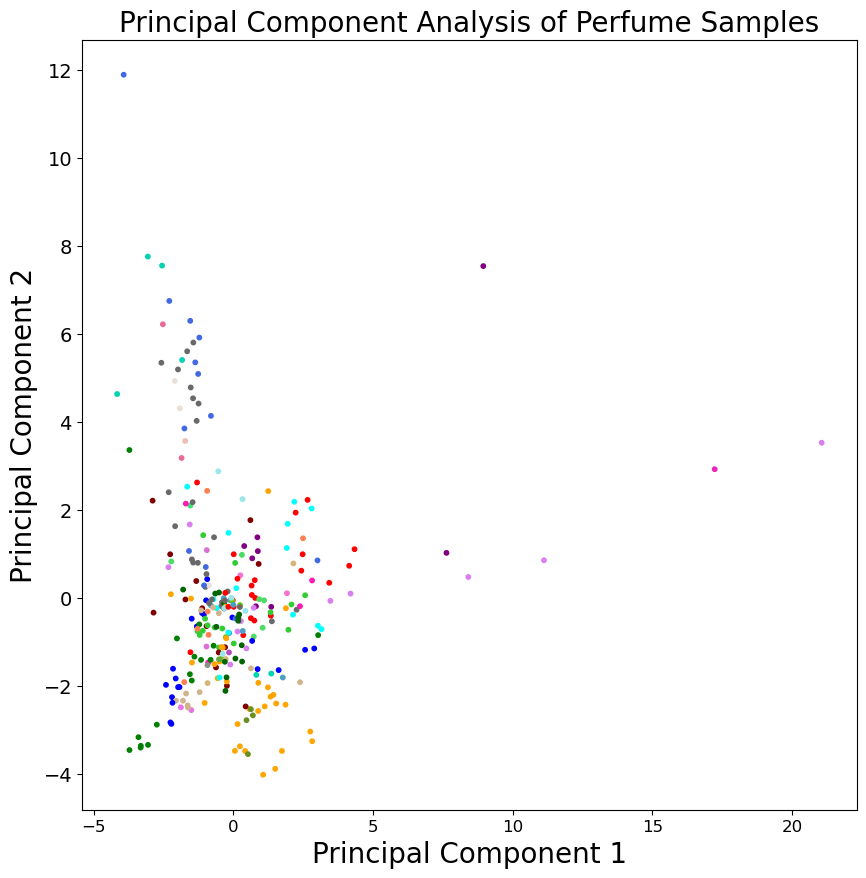

In [98]:

%matplotlib inline
#%matplotlib notebook
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis of Perfume Samples",fontsize=20)

pc1 = final_df['pc1']
pc2 = final_df['pc2']
test = final_df['Brand'].values.tolist()
test2 = final_df['Country'].values.tolist()
te = []
for i in range(len(test)):
    new_term = test[i] + ' - ' + test2[i]
    te.append(new_term)
    
plt.scatter(pc1, pc2,s = 10,c=final_df['Colour'])

for i,txt in enumerate(te):
    pass
    #plt.annotate(txt,(pc1[i], pc2[i]))

# Bokeh plot

In [111]:
from bokeh.plotting import figure, save, ColumnDataSource, output_notebook
from bokeh.models import HoverTool

In [125]:
x = final_df['pc1']
y= final_df['pc2']

ss = ColumnDataSource(data=dict(x = final_df['pc1'],
                                y = final_df['pc2'],
                                color = final_df['Colour'],
                                brand = final_df['Brand'],
                                count = final_df['Country'],
                                scent = final_df['Scent']
                               ))
p = figure(title = 'PCA analysis')
p.circle(x='x',y='y',size=3, source=ss,color='color')

hover = HoverTool(tooltips=[('Brand','@brand'),
                           ('Country','@count'),
                           ('Scent','@scent')])
p.add_tools(hover)
output_notebook()
show(p)

Loading BokehJS ...

# Plotting a dendrogram

In [126]:
from plotly.figure_factory import create_dendrogram

def chosen_opt(x):
    global chosen_label
    chosen_label = x
    dendro_df = final_df.iloc[:,:6]
    #display(dendro_df)
    labs = final_df[chosen_label].tolist()
    fig = create_dendrogram(dendro_df, 
                            labels=labs,
                            color_threshold=7
                           )
    fig.update_layout({'width':1500, 'height':1000})
    fig.show()

interact_manual(chosen_opt, x=widgets.Dropdown(options=list(dat2.columns),
                                        description='Chosen header:',
                                        align_items='stretch',
                                        style={'description_width': 'initial'}
                                       )
        )



C:\Users\bamford.s\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


interactive(children=(Dropdown(description='Chosen header:', options=('Brand', 'Manufacturer', 'Country'), sty…

<function __main__.chosen_opt(x)>

# PCA graph 2 - hovering data labels, custom colours

In [3]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
import matplotlib.colors as mcolors
import random
import matplotlib.patches as mpatches

#%matplotlib notebook
%matplotlib inline

# Loading the data x variables, y variables and the data point labels for 'names'
x = final_df['pc1']
y = final_df['pc2']

names = te #+ final_df['Scent']

#plotting graph, changing sizes and shapes of points and graph
fig,ax = plt.subplots(figsize = (10,6))
sc = plt.scatter(x,y,c=final_df['Colour'], s=10, #animated = True
                )

annot = ax.annotate("", xy=(0,0), xytext=(-50,5),textcoords="offset points", fontsize = 8,
                    arrowprops=dict(arrowstyle="->", alpha=0.5)
                   )
annot.set_visible(False)

# Plotting the legend
patches = []
for i in range(len(colour_count.keys())):
    patches.append(mpatches.Patch(color=colours[i], label=count_list[i]))

plt.legend(handles=patches,fontsize='7',loc='center left', bbox_to_anchor=(1, 0.5))

# these functions were found nline, saved to python courses bookmark
def update_annot(ind):
    
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(" ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
# This is plotting custom rings to show self identified clusters

# Mainly India + Pakistan, also one product from Turkey
circle1 = plt.Circle((1, -3), 1.2, color='darkblue', fill=False)
ax.add_patch(circle1)

# MENA (Egypt, Iran, Morocco) and UK
circle2 = plt.Circle((-2, -2.25), 0.8, color='g', fill=False)
ax.add_patch(circle2)

# Europe - Germany, Russia, Poland and France
circle3 = plt.Circle((-1.25, 5.2), 1.2, color='darkred', fill=False)
ax.add_patch(circle3)

# Large central cluster, assum,ed to be basic, similar products
circle4 = plt.Circle((-0.2, -0.5), 1.2, color='black', fill=False)
ax.add_patch(circle4)

# USA (Arm and Hammer brand) and China
circle5 = plt.Circle((2.5, 2), 0.5, color='orange', fill=False)
ax.add_patch(circle5)


fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

NameError: name 'final_df' is not defined